전이학습은 분류기만 따로 학습을 시키는 경우가 많음

#합성곱신경망 다중분류 전이학습(transfer learning) (cifer10 - 컬러이미지)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf

##1.데이터 준비

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# y_train을 보면 다른 데이터의 label과 다르게 이차원임
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
# flatten 써도 됨
y_train = y_train.reshape(-1)
y_test= y_test.reshape(-1)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [6]:
pd.Series(y_train).value_counts()

,count
6,5000
9,5000
4,5000
1,5000
2,5000
7,5000
8,5000
3,5000
5,5000
0,5000


In [7]:
samples = np.random.randint(50000, size=25)
samples

array([30649, 40936, 25359,   773, 39742, 28936,  7342, 33704, 49633,
       48389,   408, 18597,  3415,  3584,  5273, 34356, 24875,  9803,
       24970, 48553,  4900,  3556, 41033,  9709, 24480])

In [8]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship','truck']

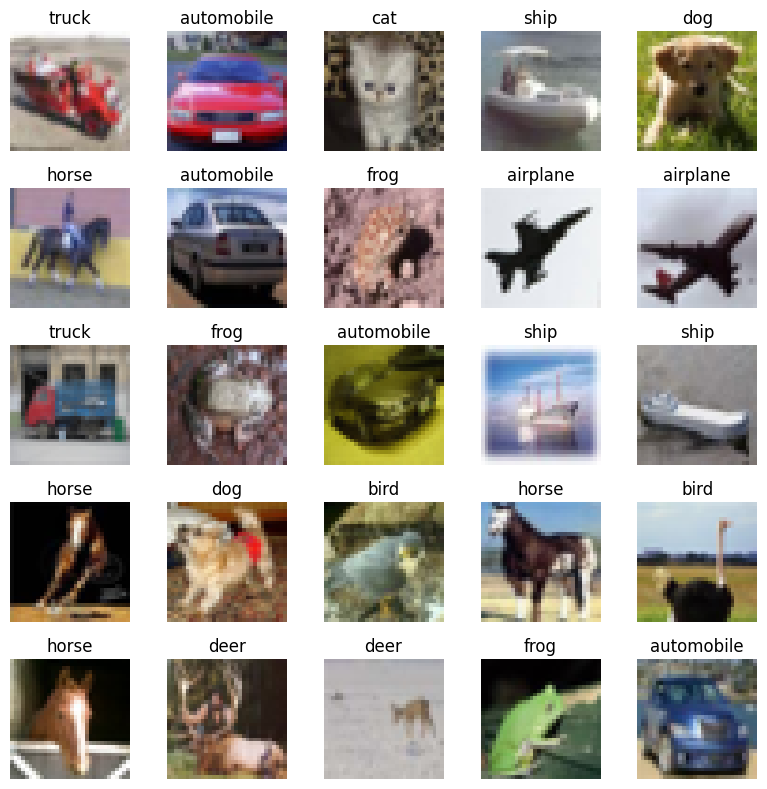

In [9]:
fig = plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
  # 한줄에 5개씩 5줄
  plt.subplot(5,5,i+1)
  plt.imshow(X_train[idx], cmap="gray")
  plt.axis('off')
  plt.title(class_name[y_train[idx]])
plt.tight_layout()
plt.show()

##4.데이터 분리

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000,), (10000,))

###스케일링
- min-max

In [12]:
X_train_s = X_train.astype('float32')/255.
X_val_s = X_val.astype('float32')/255.

###인코딩

In [13]:
from keras.utils import to_categorical

y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

In [14]:
type(X_train_s), type(y_train_o)

(numpy.ndarray, numpy.ndarray)

##5.모델 만들기

In [15]:
# 있는 모델 가져다 쓰기

from keras.applications import VGG16

base_model = VGG16(
    input_shape=(32,32,3),
    # 어떤 가중치, 어떤 학습이 된 모델을 가져오겠냐?
    weights='imagenet',
    # 앞단 뒷단 전체 다 가져올 것인가?
    include_top=False)

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 새로 학습 시키지는 않는다
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
from keras import layers

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    # 과적합이 일어나지 않도록 0.3 정도의 노드를 끊어버림
    # 배치 노멀리제이션
    layers.Dropout(0.3),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [19]:
# early stopping 콜백함수 설정
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    # 뭐를 살펴볼건가
    monitor = "val_loss",
    # 얼마나 참고 볼건가
    patience=5
)

In [20]:
epochs = 3
batch_size = 32

histroy = model.fit(X_train_s, y_train_o,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data=(X_val_s, y_val_o),
                    # 한번 돌고 확인하고
                    callbacks=[es])

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - acc: 0.4348 - loss: 1.6012 - val_acc: 0.5525 - val_loss: 1.2709
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - acc: 0.5739 - loss: 1.2183 - val_acc: 0.5835 - val_loss: 1.1769
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - acc: 0.6017 - loss: 1.1385 - val_acc: 0.5935 - val_loss: 1.1582


In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'], label='train_loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
  plt.title('Loss Curve')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['acc'], label='train_acc')
  plt.plot(hist['epoch'], hist['val_acc'], label='val_acc')
  plt.title('acc Curve')
  plt.legend()

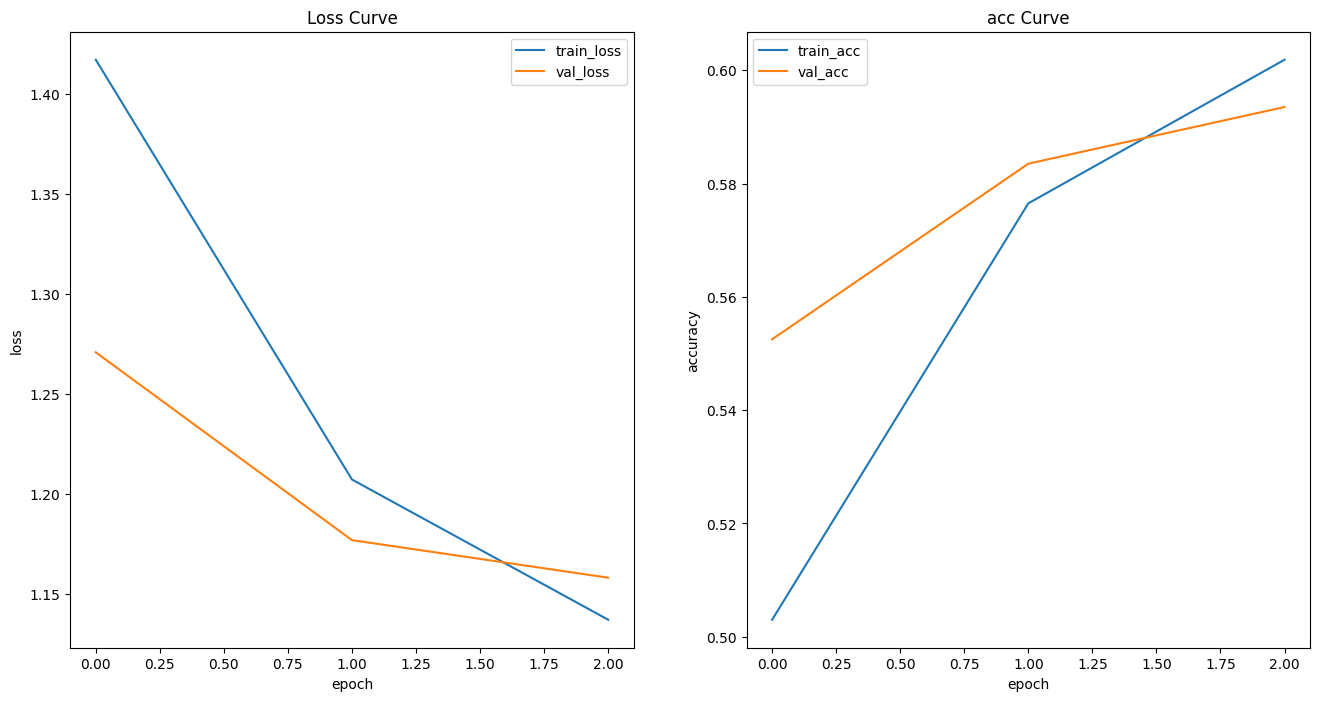

In [22]:
plot_history(histroy)

##6.테스트

In [23]:
X_test_s = X_test.astype('float32')/255.

In [24]:
y_test_o = to_categorical(y_test)

In [25]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [29]:
y_test_o = np.argmax(y_test_o, axis=1)
y_test_o

array([3, 8, 8, ..., 5, 1, 7])

In [28]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 8, 1, ..., 5, 0, 7])

In [31]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import confusion_matrix

def print_metrics(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  re = recall_score(y_true, y_pred, average='macro')
  pre = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')

  print("acc:", acc)
  print("recall:", np.around(re, 4))
  print("precision:", np.around(pre, 4))
  print("f1:", np.around(f1, 4))

  cfm = confusion_matrix(y_true, y_pred)
  s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='d', cbar=False)
  s.set(xlabel='Prediction', ylabel='Actual')
  plt.show()

acc: 0.332
recall: 0.332
precision: 0.424
f1: 0.2892


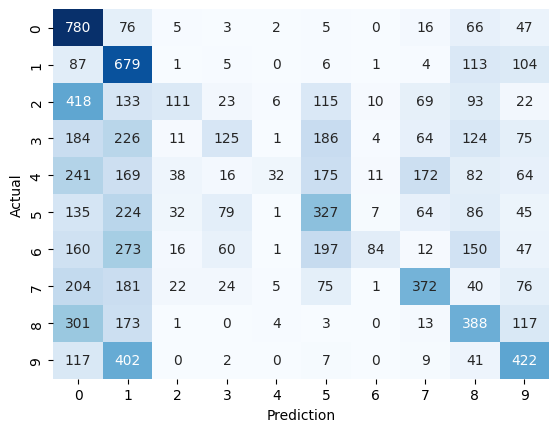

In [32]:
print_metrics(y_test, y_pred)

##7.모델 저장

In [33]:
# 이건 옛날 버전....!
model.save('cnn_multi_transfer_90.h5')

In [34]:
# 확장자를 바꾸면 워닝 안남
model.save('cnn_multi_transfer_90.keras')

In [35]:
loaded_model = keras.saving.load_model('cnn_multi_transfer_90.keras')
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,994,454 (57.20 MB)

 Trainable params: 139,882 (546.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 139,884 (546.43 KB)

In [ ]:
# savedModel 포멧 사용해서 저장
tf.saved_model.save(model, 'my_model')